In [1]:
#импорты
import pandas as pd
import numpy as np

from datetime import datetime,timedelta, date
import requests
import io

import matplotlib.pyplot as plt
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go

from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

import warnings
warnings.filterwarnings("ignore")

### 0. Подготовка датасета

In [2]:
#загрузка данных
bond_url = 'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'
s=requests.get(bond_url).content
df = pd.read_csv(io.StringIO(s.decode('windows-1251')), sep=';', header=1)

### 1. Очистка данных

In [3]:
# 1. Выбор рублевых облигаций

#доступные валюты
print('Доступные валюты:', '\n', df['FACEUNIT'].value_counts(), '\n') #смотрим облигации в каких валютах у нас есть
df_2 = df[df['FACEUNIT'] == 'RUB'].reset_index(drop = True) #выбираем рублевые облигации

# 2. Выбор релевантных колонок

#доступные колокни
print('Доступные колонки:','\n', df.columns, '\n')

#переименовывание для удобства
df_2.rename(columns = {'SECID':'ID', 
                       'FACEVALUE':'NOMINAL_VALUE',
                       'INITIALFACEVALUE':'INITIAL_NOMINAL_VALUE',
                       'FACEUNIT':'NOMINAL_CURRENCY',
                       'COUPONDATE':'COUPONDATE_NEXT',
                       'INN':'EMITENT_INN',
                       'MATDATE':'REDEMPTIONDATE'}, inplace = True)

#выбор релевантных колонок
df_2 = df_2[['EMITENTNAME', 'NAME','INITIAL_NOMINAL_VALUE',
             'COUPONPERCENT','COUPONVALUE','COUPONFREQUENCY',
             'COUPONDATE_NEXT','COUPONDAYSPASSED','COUPONDAYSREMAIN',
             'COUPONLENGTH','PRICE_RUB','ISSUEDATE','REDEMPTIONDATE',
             'DAYSTOREDEMPTION','HIGH_RISK']]

# 3. Перевод в корректный формат данных

#типы данных до исправления
print('Типы данных до исправления:\n',df_2.dtypes, '\n')

#функция, исправляющая типы данных
def type_changer(x):
    if isinstance(x,str):
        x_new_type = float(x.replace(',','.'))
    else:
        x_new_type = x
    return x_new_type
    

#перевод строковых данных в числовые
for col in ['INITIAL_NOMINAL_VALUE', 'COUPONPERCENT', 'COUPONVALUE',
            'COUPONDAYSPASSED', 'COUPONDAYSREMAIN','COUPONLENGTH', 'PRICE_RUB']:
    df_2[col] = df_2[col].apply(type_changer)
    
#перевод строковых данных в datetime
for col in ['COUPONDATE_NEXT','ISSUEDATE', 'REDEMPTIONDATE']:
    df_2[col] = pd.to_datetime(df_2[col])

#типы данных после исправления
print('Типы данных после исправления:\n',df_2.dtypes, '\n')
# 4. Обработка пропусков

#кол-во строк до обработки пропусков
samples_before = df_2.shape[0]
print('Просмотр пропусков до обработки:\n',df_2.isnull().sum(), '\n')

#замена прпоусков у купона в относит.выражении
df_2['COUPONPERCENT'].replace(np.nan,0,inplace = True) # COUPONPERCENT - пропуск означает бескупонную облигацию

#замена прпоусков у купона в абсолбтном выражении
condition = (df_2['COUPONPERCENT'].notna()) & (df_2['COUPONVALUE'].isna()) & (df_2['COUPONFREQUENCY'].notna())
df_2['COUPONVALUE'].loc[condition] = (df_2['COUPONPERCENT']*df_2['INITIAL_NOMINAL_VALUE'])/df_2['COUPONFREQUENCY']# COUPONVALUE - вычисляем по формуле

#удаление пропусков в прочих колонках
for col in ['COUPONFREQUENCY','COUPONDATE_NEXT','COUPONDAYSPASSED',
            'COUPONDAYSREMAIN','COUPONLENGTH','PRICE_RUB',
            'ISSUEDATE','REDEMPTIONDATE','DAYSTOREDEMPTION']:
    
    df_2 = df_2[df_2[col].isnull() == False].reset_index(drop = True)
    
#кол-во строк после обработки пропусков
print('Просмотр пропусков после обработки:\n',df_2.isnull().sum(), '\n')

# 5. Добавление нужных полей

#срок погашения облигации
df_2['DAYSTOREDEMPTION_SINCE_START'] = df_2['REDEMPTIONDATE'] - df_2['ISSUEDATE'] 
df_2['DAYSTOREDEMPTION_SINCE_START'] = df_2['DAYSTOREDEMPTION_SINCE_START'].apply(lambda x: x.days)

#сегодняшняя дата
df_2['TODAY'] = date.today() 
df_2['TODAY'] = pd.to_datetime(df_2['TODAY'])

#дата последней выплаты купона
df_2['COUPONDATE_LAST'] = df_2.apply(lambda x: x['TODAY'] - timedelta(days = x['COUPONDAYSPASSED']), axis = 1) 

# 6. Уберем ошибки в расчете даты выплаты купона

#удаление строк где неверно рассчитана дата следующей выплаты купона.
df_3 = df_2.copy()
df_3['is_mistake_in_coupon_date'] = df_3.apply(lambda x: 0 if x['COUPONDATE_NEXT'] - timedelta(days = x['COUPONDAYSREMAIN']) == x['TODAY'] else 1, axis = 1)
df_3 = df_3[df_3['is_mistake_in_coupon_date'] == 0].reset_index(drop = True)

#кол-во строк которое было удалено
samples_after = df_3.shape[0]
print('Удалено строк:', samples_before - samples_after, '\n')

# 7. Сформируем итогвоый датасет с удобным расположением колонок

df_3 = df_3[['EMITENTNAME','NAME','INITIAL_NOMINAL_VALUE','COUPONPERCENT','COUPONVALUE',
             'COUPONFREQUENCY','COUPONDATE_LAST','COUPONDAYSPASSED','TODAY','COUPONDAYSREMAIN',
             'COUPONDATE_NEXT','COUPONLENGTH','PRICE_RUB','ISSUEDATE','REDEMPTIONDATE',
             'DAYSTOREDEMPTION_SINCE_START','DAYSTOREDEMPTION','HIGH_RISK']]

Доступные валюты: 
 RUB    2365
USD     339
EUR      46
CHF       9
GBP       2
Name: FACEUNIT, dtype: int64 

Доступные колонки: 
 Index(['SECID', 'SHORTNAME', 'NAME', 'TYPENAME', 'ISIN', 'REGNUMBER',
       'LISTLEVEL', 'FACEVALUE', 'FACEUNIT', 'ISSUESIZE', 'IS_COLLATERAL',
       'IS_EXTERNAL', 'PRIMARY_BOARDID', 'PRIMARY_BOARD_TITLE', 'MATDATE',
       'IS_RII', 'DURATION', 'EVENINGSESSION', 'MORNINGSESSION',
       'IS_QUALIFIED_INVESTORS', 'HIGH_RISK', 'COUPONFREQUENCY', 'YIELDATWAP',
       'COUPONDATE', 'COUPONPERCENT', 'COUPONVALUE', 'COUPONDAYSPASSED',
       'COUPONDAYSREMAIN', 'COUPONLENGTH', 'ISSUEDATE', 'INITIALFACEVALUE',
       'SECSUBTYPE', 'STARTDATEMOEX', 'DAYSTOREDEMPTION', 'OFFERDATE',
       'EMITENTNAME', 'INN', 'LOTSIZE', 'PRICE', 'PRICE_RUB', 'RTL1', 'RTH1',
       'RTL2', 'RTH2', 'RTL3', 'RTH3', 'DISCOUNT1', 'LIMIT1', 'DISCOUNT2',
       'LIMIT2', 'DISCOUNT3', 'DISCOUNTL0', 'DISCOUNTH0'],
      dtype='object') 

Типы данных до исправления:
 EMITENTNAME        

### 2. Расчет полной купонной доходности к погашению

In [4]:
#accumulated coupon income(ACI)
df_3['ACI_period'] = df_3['COUPONDAYSPASSED']/df_3['COUPONLENGTH'] # доля периода выплаты купона (накопелнная)
#df_3 = df_3[df_3['ACI_period'] <= 0.2].reset_index(drop = True) # выбор значений <= 0.2
df_3['ACI'] = df_3['ACI_period'] * (((df_3['COUPONPERCENT']/100)/df_3['COUPONFREQUENCY']) * df_3['INITIAL_NOMINAL_VALUE'])

#future coupon income(FCI)
df_3['FCI_period'] = 365/df_3['COUPONLENGTH'] #период расчета 365 дней с текущей даты
df_3['FCI'] = df_3['FCI_period'] * (((df_3['COUPONPERCENT']/100)/df_3['COUPONFREQUENCY']) * df_3['INITIAL_NOMINAL_VALUE']) * 0.87

#tax
df_3['TAX'] = 0.87
df_3['TAX'].loc[df_3['INITIAL_NOMINAL_VALUE'] <= df_3['PRICE_RUB']] = 1

In [5]:
#входные параметры
N = df_3['INITIAL_NOMINAL_VALUE']
P = df_3['PRICE_RUB']
tax = df_3['TAX']
FCI = df_3['FCI']
ACI = df_3['ACI']

#комиссии брокера и биржи
broker_com = 0.06/100
exchange_com = 0.0125/100

#расчет полной купонной доходности
df_3['PROFIT'] = ((N-P)*tax + (FCI-ACI))/(1+broker_com+exchange_com)
df_3['COSTS'] = P+ACI
df_3['YIELD_FULL'] = (df_3['PROFIT']/df_3['COSTS']) * 100

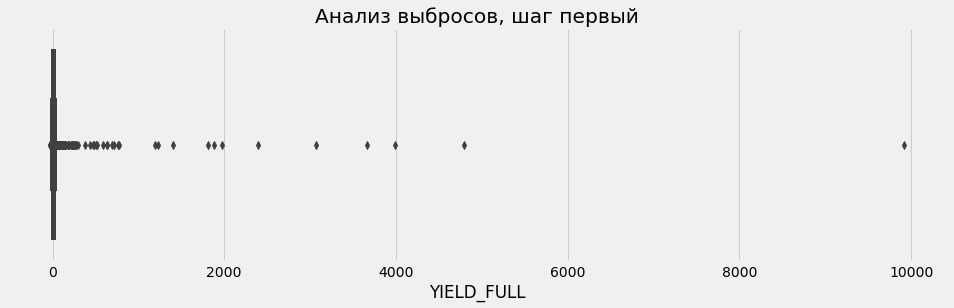

In [6]:
#boxplot полной купонной доходности к погашению
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,4))
sns.boxplot(df_3['YIELD_FULL'])
plt.title('Анализ выбросов, шаг первый')
plt.show()

#удалим выбросы с доходностью больше 100
df_4 = df_3[(df_3['YIELD_FULL'] <= 100)].reset_index(drop = True)

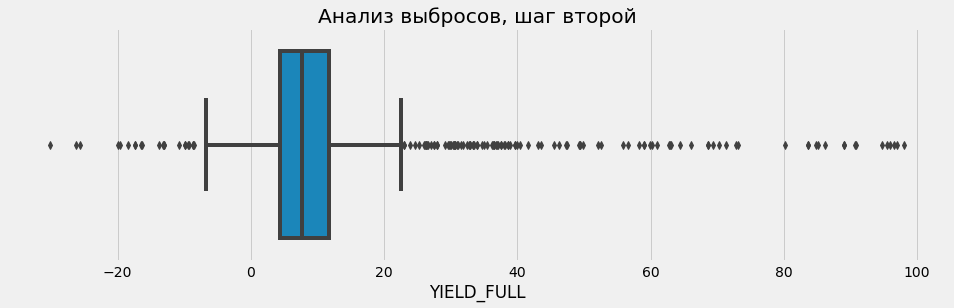

In [7]:
# boxplot полной купонной доходности к погашению после удаления выбросов
plt.figure(figsize = (15,4))
sns.boxplot(df_4['YIELD_FULL'])
plt.title("Анализ выбросов, шаг второй")
plt.show()

### 3. Рынок рублевых облигаций

In [8]:
# эмитенты, которые выпустили больше всех облигаций
df_4_emitents = df_4.groupby('EMITENTNAME').agg({'NAME':'count'}).reset_index().sort_values('NAME', ascending = False)

# средняя номинальная стоимость, купон, цена выкупа, срок погашения и полная доходность к погашению по рынку
df_4.describe().loc['mean'][['INITIAL_NOMINAL_VALUE',
                             'COUPONPERCENT',
                             'PRICE_RUB',
                             'DAYSTOREDEMPTION_SINCE_START',
                             'YIELD_FULL']]

INITIAL_NOMINAL_VALUE           63667.232598
COUPONPERCENT                       7.110484
PRICE_RUB                       60383.540178
DAYSTOREDEMPTION_SINCE_START     2738.402377
YIELD_FULL                         10.917476
Name: mean, dtype: float64

#### 3.1 Распредления

<AxesSubplot:title={'center':'Распределение COUPONPERCENT'}, ylabel='Frequency'>

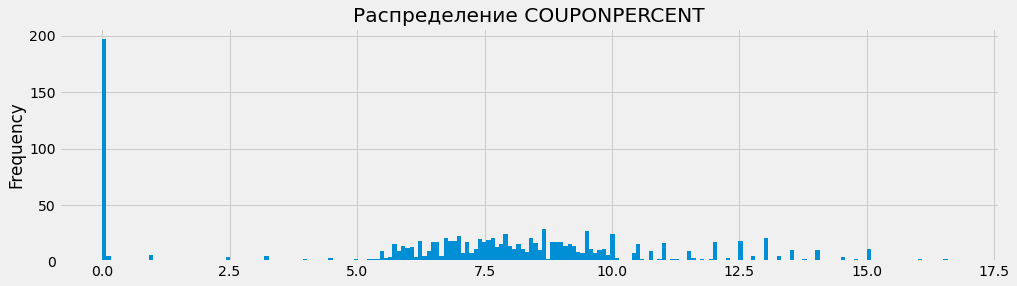

In [9]:
#распределение COUPONPERCENT
plt.style.use('fivethirtyeight')
df_4['COUPONPERCENT'].plot(kind = 'hist',
                           figsize = (15,4),
                           bins = 200,
                           title = 'Распределение COUPONPERCENT',
                           xlabel = 'COUPONPERCENT')

<AxesSubplot:title={'center':'Распределение доходности к пошагению'}, ylabel='Frequency'>

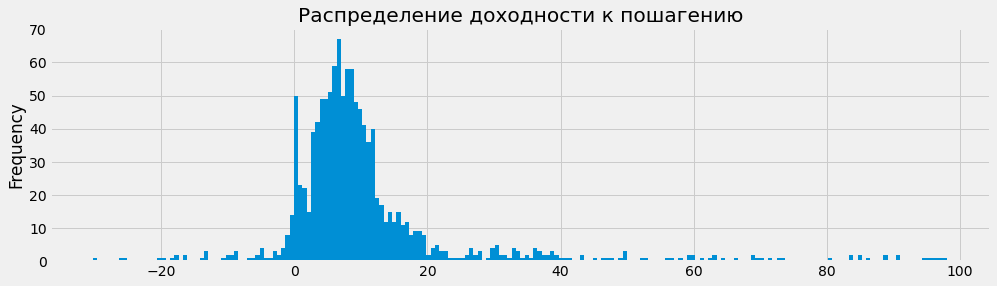

In [10]:
#распределение полной купонной доходности к погашению (гистограмма)
df_4['YIELD_FULL'].plot(kind = 'hist',
                   figsize = (15,4),
                   bins = 200,
                   title = 'Распределение доходности к пошагению',
                   xlabel = 'YIELD_FULL')

### 3. Кластеризация по полной доходности к погашению

In [11]:
#параметры купонной доходности
x_init = df_4['YIELD_FULL']
X = x_init.values.reshape(-1, 1)

#### 3.1 Распределение доходности к погашению (плотность)

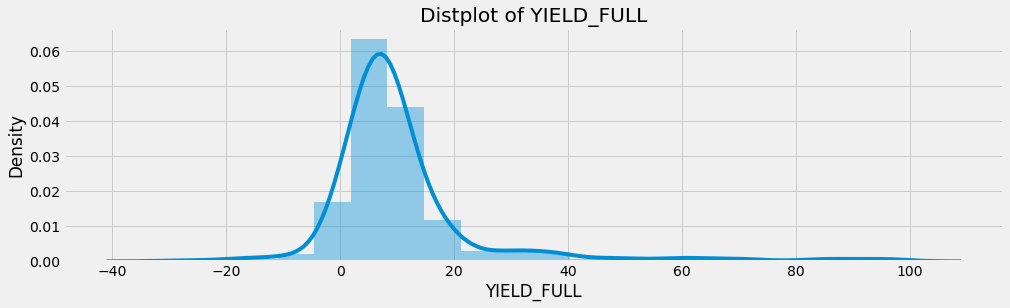

In [12]:
#параметры графика
plt.figure(figsize = (15,4))
true_dens = sns.distplot(x_init,
                         bins = 20,
                         norm_hist = True).get_lines()[0].get_data()[1] #получение y точек плотности распредления 
plt.title(f'Distplot of {x_init.name}')
plt.show()

#### 3.2 Возможные ядерные функции (K)

Text(0.5, 1.0, 'Available Kernels')

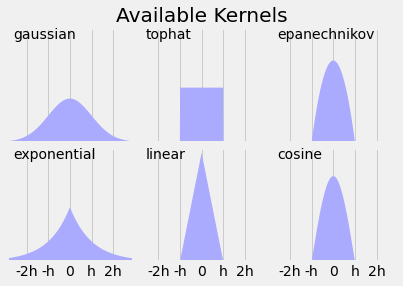

In [13]:
#входные параметры
X_plot = np.linspace(-6, 6, len(X))[:, None]
X_src = np.zeros((1, 1))
kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]

#параметры гарфика
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)

def format_func(x, loc):
    if x == 0:
        return "0"
    elif x == 1:
        return "h"
    elif x == -1:
        return "-h"
    else:
        return "%ih" % x

#отрисовка плотностей доступных ядерных функций
for i, kernel in enumerate(kernels):
    
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), "-k", fc="#AAAAFF")
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title("Available Kernels")

#### 3.3 Ядерный оценщик YIELD_FULL (1/nh * sum(K((x-x_i/h))))

<Figure size 432x288 with 0 Axes>

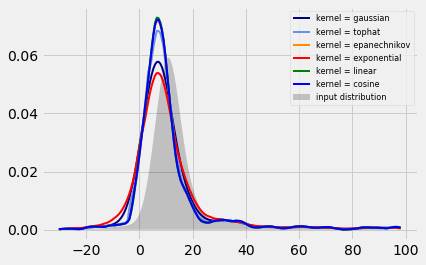

In [14]:
#входные параметры
X_plot = np.linspace(np.min(x_init), np.max(x_init), len(true_dens))
h = 1.06 * x_init.std() * (len(x_init)**(-1/5)) #ширина полосы
colors = ["navy", "cornflowerblue", "darkorange",'red','green','blue']
kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]

#параметры графика
plt.figure()
fig, ax = plt.subplots()
ax.fill(X_plot.reshape(-1, 1)[:, 0],
        true_dens,
        fc="black", 
        alpha=0.2,
        label="input distribution")

lw = 2

#отрисовка плотности каждого ядерного оценщика
for color, kernel in zip(colors, kernels):
    
    kde = KernelDensity(kernel=kernel, bandwidth=h).fit(X)
    log_dens = kde.score_samples(X_plot.reshape(-1, 1))
    
    ax.plot(X_plot.reshape(-1, 1)[:, 0],
            np.exp(log_dens),
            color=color,
            lw=lw,
            linestyle="-",
            label=f'kernel = {kernel}')
    
ax.legend(loc='best', fontsize = 'xx-small')
plt.show()

#### 3.4 Кластеризация при помощи разных kernels. выбор наилучшего.

Grouping kernel gaussian:
[29.75268775 54.24251903 77.44341181]
Grouping kernel tophat:
[-21.80485176  -8.91546688  25.88587229  32.33056473  47.79782659
  51.66464205  54.24251903  64.55402693  67.1319039   68.42084239
  84.53257349  90.33279669  92.91067366]
Grouping kernel epanechnikov:
[-26.31613647 -23.7382595  -22.44932101 -17.29356706 -13.42675159
  -9.55993613  25.88587229  34.26397246  43.93101112  53.59804978
  66.48743466  76.79894256  85.17704274  92.91067366]
Grouping kernel exponential:
[-25.02719798  48.44229583  54.24251903  61.97614995  67.1319039
  77.44341181  87.75491971  92.91067366]
Grouping kernel linear:
[-29.53848269 -14.71569008  -8.27099764  25.24140305  34.26397246
  43.93101112  54.24251903  66.48743466  76.79894256  87.75491971
  92.91067366]
Grouping kernel cosine:
[-26.31613647 -22.44932101 -16.64909781 -13.42675159  -9.55993613
  25.88587229  34.26397246  43.93101112  53.59804978  66.48743466
  76.79894256  85.17704274  92.91067366]


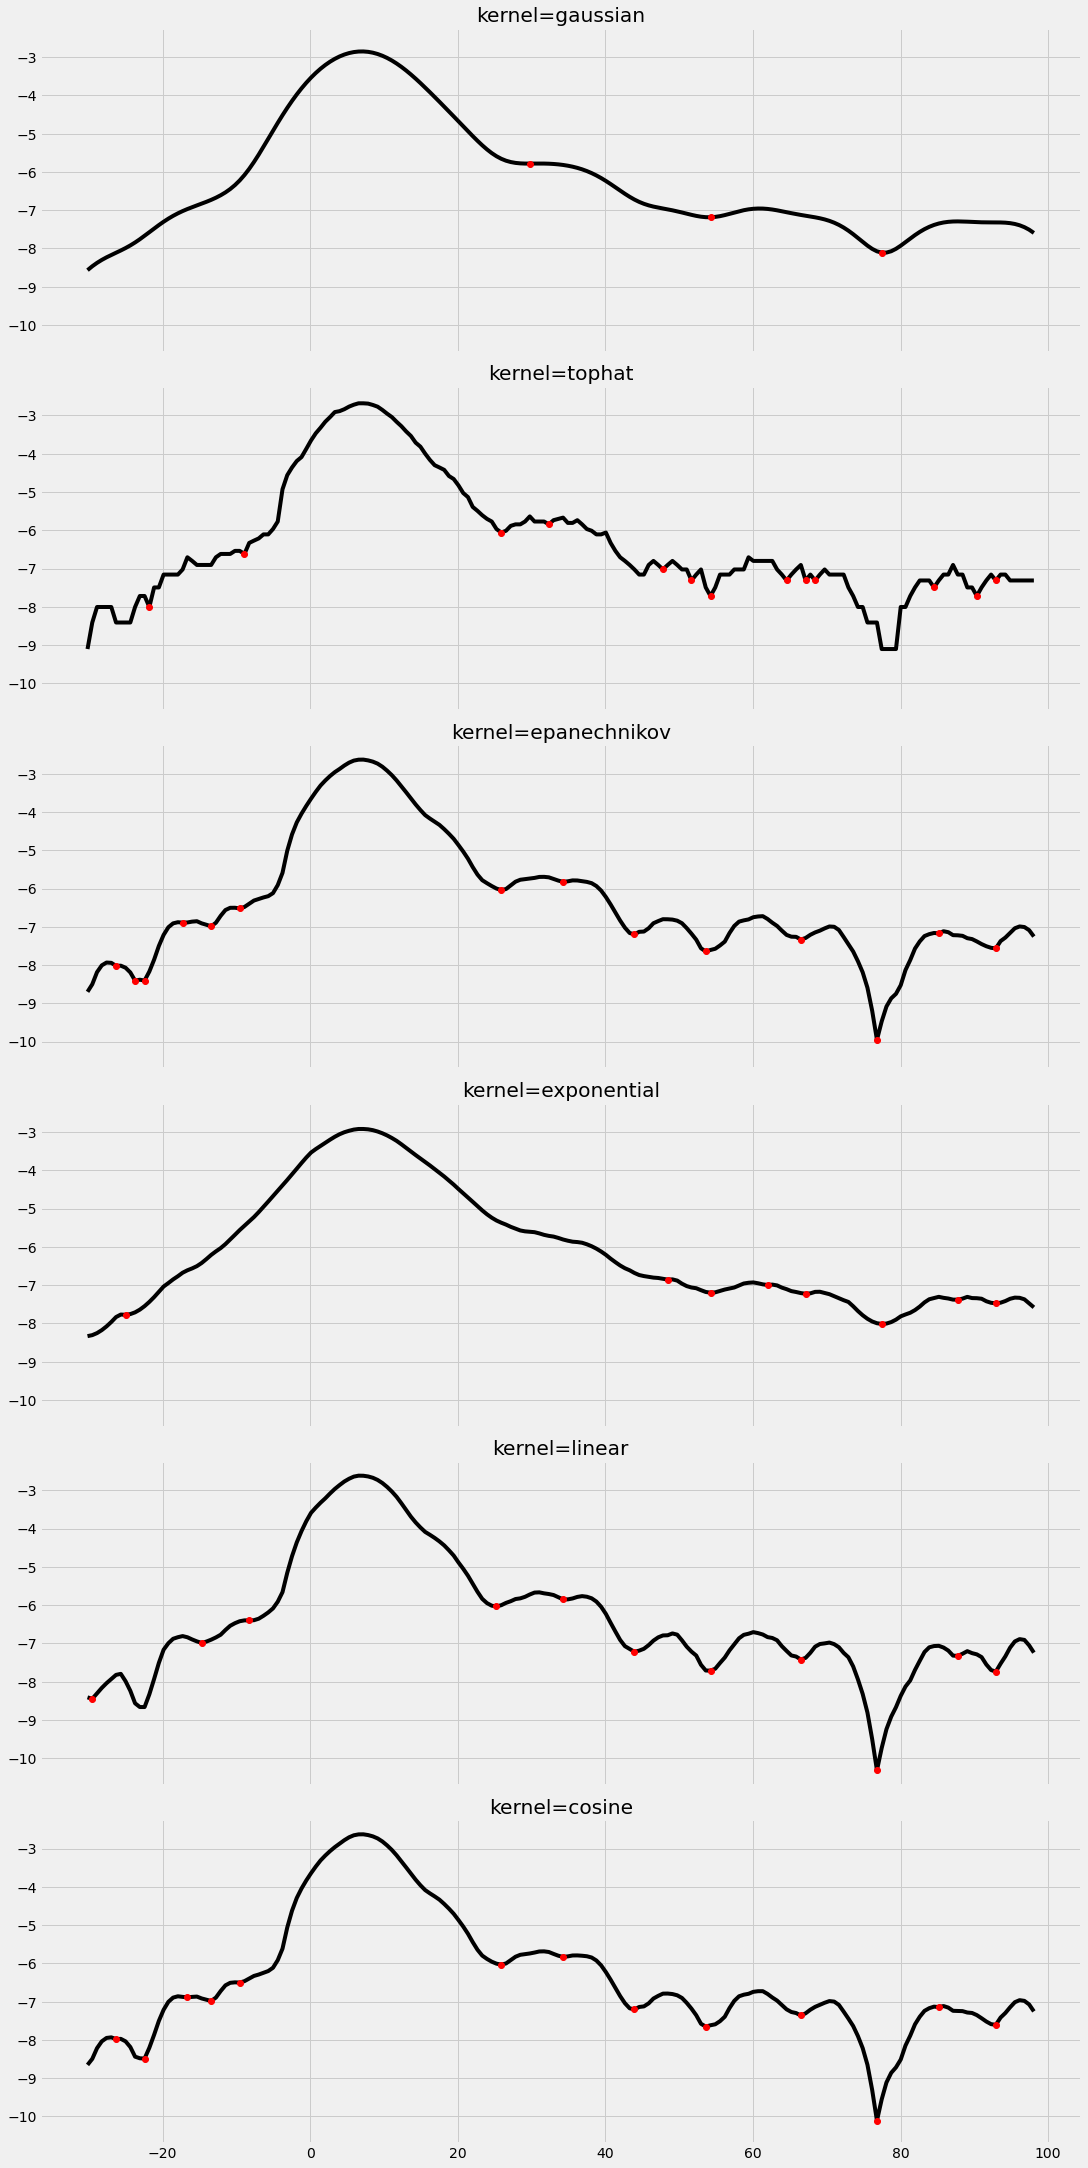

In [15]:
#общие параметры графика
rows = len(kernels)
cols = 1
axs = plt.figure(figsize=(15,30),
                 constrained_layout=True).subplots(rows,
                                                   cols,
                                                   sharex=True,
                                                   sharey=True)

#отрисовка кластеризации при помощи каждого kernel
for ax, kernel in zip(axs,kernels):
    
    kde = KernelDensity(kernel=kernel, bandwidth=h).fit(X)
    log_dens = kde.score_samples(X_plot.reshape(-1, 1))
    min_, max_ = argrelextrema(log_dens, np.less)[0], argrelextrema(log_dens, np.greater)[0]
    
    print(f'Grouping kernel {kernel}:')
    if len(min_) > 1:
        print(X_plot[min_])
        ax.set_title('kernel=%s' % str(kernel))
        ax.plot(X_plot, log_dens, 'black',
                 X_plot[min_], log_dens[min_], 'ro')
    else:
        print('error')

#### 3.5 Кластеризация при помощи лучшего kernel: epanechnikov

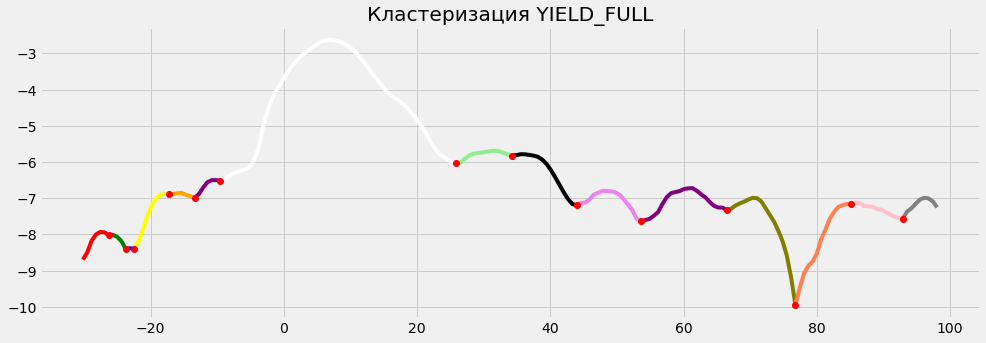

In [16]:
#расчет границ интервалов кластеризации
kde = KernelDensity(kernel='epanechnikov', bandwidth=h).fit(X)
s = X_plot  #для удобства задания параметров гарфика
e = kde.score_samples(s.reshape(-1, 1)) #для удобства задания параметров гарфика
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]

#отрисовка гарфика
plt.figure(figsize=(15,5))
plt.plot(s[:mi[0]+1], e[:mi[0]+1], 'red',
         s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'green',
         s[mi[1]:mi[2]+1], e[mi[1]:mi[2]+1], 'blue',
         s[mi[2]:mi[3]+1], e[mi[2]:mi[3]+1], 'yellow',
         s[mi[3]:mi[4]+1], e[mi[3]:mi[4]+1], 'orange',
         s[mi[4]:mi[5]+1], e[mi[4]:mi[5]+1], 'purple',
         s[mi[5]:mi[6]+1], e[mi[5]:mi[6]+1], 'white',
         s[mi[6]:mi[7]+1], e[mi[6]:mi[7]+1], 'lightgreen',
         s[mi[7]:mi[8]+1], e[mi[7]:mi[8]+1], 'black',
         s[mi[8]:mi[9]+1], e[mi[8]:mi[9]+1], 'violet',
         s[mi[9]:mi[10]+1], e[mi[9]:mi[10]+1], 'purple',
         s[mi[10]:mi[11]+1], e[mi[10]:mi[11]+1], 'olive',
         s[mi[11]:mi[12]+1], e[mi[11]:mi[12]+1], 'coral',
         s[mi[12]:mi[13]+1], e[mi[12]:mi[13]+1], 'pink',
         s[mi[13]:], e[mi[13]:], 'gray',
         s[mi], e[mi], 'ro')
plt.title('Кластеризация YIELD_FULL')
plt.show()